# SGD with MNIST Sample dataset

In [1]:
import fastbook
from fastbook import *

In [2]:
# Get the dataset of 3s & 7s
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
train_images = get_image_files(path/"train")
valid_images = get_image_files(path/"valid")

In [4]:
def image_read(x): return tensor(Image.open(x))/255.

In [5]:
train_tensors = torch.stack([image_read(x) for x in train_images])
valid_tensors = torch.stack([image_read(x) for x in valid_images])

In [6]:
train_tensors = train_tensors.view(-1, 28 * 28)
valid_tensors = valid_tensors.view(-1, 28 * 28)

In [19]:
train_targets = torch.tensor([[1] if parent_label(x) == '3' else [0] for x in train_images])
valid_targets = torch.tensor([[1] if parent_label(x) == '3' else [0] for x in valid_images])

In [25]:
# Create a dataset i.e. (x, y) tuples for train set
train_dset = list(zip(train_tensors, train_targets))
x, y = train_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [26]:
# Create a dataloader for train set
train_dl = DataLoader(train_dset, batch_size = 64)
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64, 1]))

In [27]:
# Create dataset & dataloader for validation set
valid_dset = list(zip(valid_tensors, valid_targets))
valid_dl = DataLoader(valid_dset, batch_size = 64)

In [163]:
def initialize_wandb(random_ = True):
    if random_:
        weights = torch.randn((28 * 28, 1)).requires_grad_()
    else:
        weights = train_tensors.mean(axis = 0).unsqueeze(1).requires_grad_()
    biases = torch.randn(1).requires_grad_()
    return(weights, biases)

def sigmoid(x):
    return 1. / (1. + torch.exp(x))

def forward(batch, w, b):
    return sigmoid(batch@w + b)

def rmse_loss(preds, targets):
    return ((preds - targets) ** 2).sum().mean()

In [164]:
def train_and_validate(weights, biases, nepochs = 20, bs = 64, lr = 1e-3, shuffle = False):
    # Create a dataloader for train and validation sets with given batch_size
    train_dl = DataLoader(train_dset, batch_size = bs, shuffle = shuffle)
    valid_dl = DataLoader(valid_dset, batch_size = bs, shuffle = shuffle)
    
    train_losses = []
    validation_losses = []

    # Define the training loop
    for epoch in progress_bar(range(nepochs), comment = f"Training for {nepochs} epochs with batch size of {bs}"):
        losses = []
        for xb, yb in train_dl:
            # Forward pass
            predictions = forward(xb, weights, biases)
            
            # loss computation
            loss = rmse_loss(predictions, yb)
            
            # Gradient computation
            loss.backward()
            
            # Weight updation
            weights.data -= lr * weights.grad.data
            biases.data -= lr * biases.grad.data
            
            # Stop accumulation of gradients
            weights.grad = None
            biases.grad = None
            
            # Record the losses
            losses.append(loss.item())
            
        # Record all the train losses for this epoch 
        train_losses.append(losses)
      
        # Check the validation set loss
        losses = []
        with torch.no_grad():
            for xb, yb in valid_dl:
                # Forward pass
                predictions = forward(xb, weights, biases)
                
                # Loss computation
                loss = rmse_loss(predictions, yb)
                
                # Append the loss
                losses.append(loss.item())
        
        # Record all the validation losses for this epoch
        validation_losses.append(losses)
    
    return (train_losses, validation_losses)

# SGD v/s MBSGD v/s GD

In [120]:
# Stochastic Gradient Descent
wSGD, bSGD = initialize_wandb()
tlsSGD, vlsSGD= train_and_validate(wSGD, bSGD, bs = 1)

In [121]:
# Minibatch Gradient Descent
wMBSGD, bMBSGD = initialize_wandb()
tlsMBSGD, vlsMBSGD= train_and_validate(wMBSGD, bMBSGD, bs = 64)

In [122]:
# Gradient Descent
wGD, bGD = initialize_wandb()
tlsGD, vlsGD= train_and_validate(wGD, bGD, bs = len(train_dset))

In [111]:
def summarize_learning(tls, vls, step = 5):
    batches = len(tls) // step
    
    # TODO: figure out the layout of plots (i.e. nrows x ncols)
    fig, ax = plt.subplots(2, 2, figsize = (15, 8), sharey = True)
    ax = ax.flatten()
    
    step_tls = [tls[x * step] for x in range(batches)]
    step_vls = [vls[x * step] for x in range(batches)]
    
    loss_comparisons = list(zip(step_tls, step_vls))
    
    for idx, (loss, axis) in enumerate(zip(loss_comparisons, ax)):
        t, v = loss
        axis.plot(range(len(t)), t)
        axis.plot(range(len(v)), v)
        axis.set_title(f"Batch losses for epoch {idx * step}")
    
    fig.suptitle("Summarizing the training for MNIST sample dataset")
    fig.tight_layout()

In [113]:
# summarize_learning(tlsSGD, vlsSGD)

In [114]:
# summarize_learning(tlsSh, vlsSh)

In [118]:
f = lambda x: [np.mean(y) for y in x]

comparison_df = pd.DataFrame({"epoch": list(range(len(tlsSGD))),
                              "SGD_train_loss": f(tlsSGD),
                              "MinibatchSGD_train_loss": f(tlsMBSGD),
                              "GD_train_loss": f(tlsGD),
                              "SGD_valid_loss": f(vlsSGD),
                              "MinibatchSGD_valid_loss": f(vlsMBSGD),
                              "GD_valid_loss": f(vlsGD),
                             })

comparison_df

In [119]:
f = lambda x, bs: [np.mean(y)/ bs for y in x]

comparison_df = pd.DataFrame({"epoch": list(range(len(tlsSGD))),
                              "SGD_train_loss": f(tlsSGD, 1),
                              "MinibatchSGD_train_loss": f(tlsMBSGD, 64),
                              "GD_train_loss": f(tlsGD, len(train_dset)),
                              "SGD_valid_loss": f(vlsSGD, 1),
                              "MinibatchSGD_valid_loss": f(vlsMBSGD, 64),
                              "GD_valid_loss": f(vlsGD, len(valid_dset)),
                             })

# comparison_df

In [135]:
def get_valid_accuracy(weights, biases):
    valid_dl = DataLoader(valid_dset, batch_size = len(valid_dset), shuffle = False)
    with torch.no_grad():
        xb, yb = next(iter(valid_dset))

        # Forward pass
        predictions = forward(xb, weights, biases)

        # Compute the labels
        predictions_10 = torch.where(predictions > 0.5, 1, 0)
        
        # Compute accuracy
        acc = torch.where(predictions_10 == yb, 1.0, 0.).mean()
        
        # Compute error
        error = torch.where(predictions_10 != yb, 1.0, 0.).mean()
            
    return acc, error

In [136]:
get_valid_accuracy(wSGD, bSGD)

(tensor(1.), tensor(0.))

In [137]:
get_valid_accuracy(wMBSGD, bMBSGD)

(tensor(1.), tensor(0.))

In [138]:
get_valid_accuracy(wGD, bGD)

(tensor(1.), tensor(0.))

# Random Initialization v/s Mean value initialization of weights

In [177]:
# Stochastic Gradient Descent
wm, bm = initialize_wandb(random_= False)
tlsm, vlsm= train_and_validate(wm, bm, bs = 64, shuffle = False)

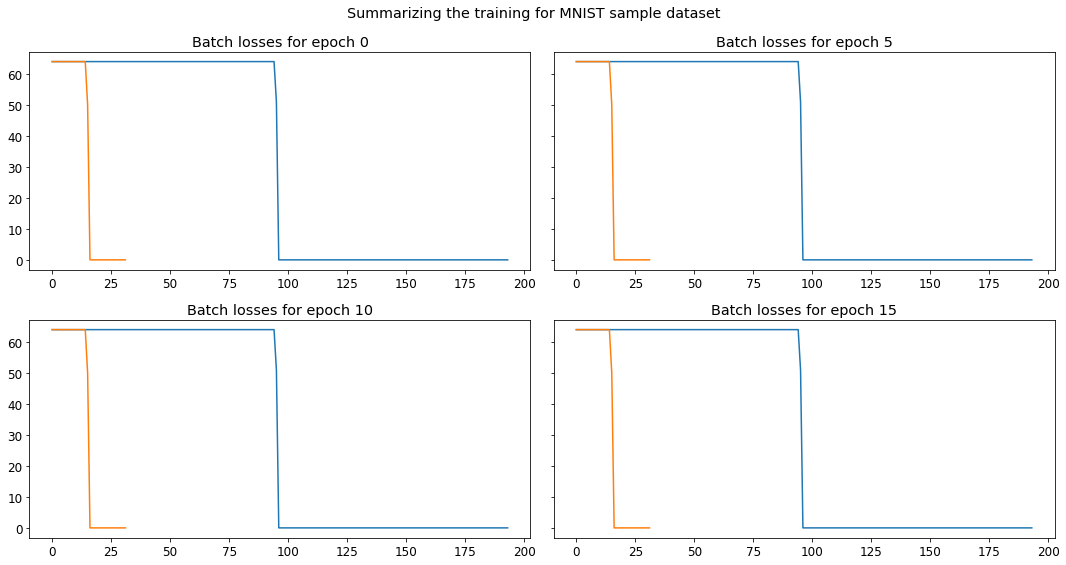

In [178]:
## TODO: Investigate later
summarize_learning(tlsm, vlsm)

In [179]:
get_valid_accuracy(wm, bm)

(tensor(0.), tensor(1.))